In [2]:
import os
from time import sleep
from tqdm import tqdm

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, Dropout
from keras import regularizers

from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns


2025-05-06 10:31:12.615972: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 10:31:12.627952: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 10:31:12.718116: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-06 10:31:12.789470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746545472.850454  615721 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746545472.86

In [3]:
# base_path = '/Users/nicholastey/Desktop/thesis/gnss_spoof_detector/spoof_detector/data/'
# base_path = 'C:/Users/nicho/Desktop/gnss_spoof_detector/spoof_detector/data'
base_path = '/home/nicholastey/gnss_spoof_detector/spoof_detector/data/'

In [4]:
cs_path, ds1_path, ds3_path, ds2_path, ds4_path, ds7_path, ds8_path = [os.path.join(base_path, ds_path) for ds_path in os.listdir(base_path)]

In [5]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 
           'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 
           'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
    tmp_path = os.path.join(base_path, ds_fname)
    key = ds_fname.split('.')[0]
    
    tmp_df = pd.read_csv(tmp_path, header=None)
    prn_li = []
    
    for i in range(8):
        prn_li.append(int(tmp_df.iloc[1, 11*i+1]))

    globals()[f'{key}_dict'] = {
        int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:11].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:22].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:33].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:44].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:55].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:66].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:77].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:88].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        'prn' : prn_li
    }


In [6]:
big_df = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 2),
    (ds3_dict, 3),
    (ds4_dict, 4),
    (ds7_dict, 5),
    (ds8_dict, 6)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df = dataset[prn].copy()
        df['spoofed'] = label
        df['prn'] = prn
        big_df.append(df)

big_df = pd.concat(big_df, ignore_index=True)
print(big_df.shape)
print(big_df.columns)
print(big_df['spoofed'].value_counts(normalize=True))

big_df

(189272, 12)
Index(['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs',
       'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz',
       'pseudorange_m', 'rx_time', 'spoofed'],
      dtype='object')
spoofed
6    0.146963
5    0.146963
1    0.145272
4    0.143920
2    0.142060
3    0.138002
0    0.136819
Name: proportion, dtype: float64


,channel,prn,acq_doopler_hz,acq_doppler_step,fs,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time,spoofed
0,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
1,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
2,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
3,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
4,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
189267,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189268,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189269,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189270,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6


In [7]:
big_df.drop(columns=['channel', 'fs', 'acq_doppler_step', 'pseudorange_m', 'acq_doopler_hz'], inplace=True)
big_df
print(big_df.shape)
print(big_df.columns)
print(big_df.isna().sum())


(189272, 7)
Index(['prn', 'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz',
       'rx_time', 'spoofed'],
      dtype='object')
prn                   0
prompt_i              0
prompt_q              0
cn0_db_hz             0
carrier_doppler_hz    0
rx_time               0
spoofed               0
dtype: int64


In [8]:
# Sort by PRN and rx_time (in case it's not already)
big_df = big_df.sort_values(by=['prn', 'rx_time'])

# Define a rolling window size
window_size = 1000

# Apply rolling stats grouped by PRN
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df[f'{col}_roll_mean'] = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    big_df[f'{col}_roll_std']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
    big_df[f'{col}_roll_min']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).min())
    big_df[f'{col}_roll_max']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).max())

big_df[['prn', 'cn0_db_hz', 'carrier_doppler_hz', 'cn0_db_hz_roll_mean', 'cn0_db_hz_roll_std', 'cn0_db_hz_roll_min', 'cn0_db_hz_roll_max', 'carrier_doppler_hz_roll_mean', 'carrier_doppler_hz_roll_std', 'carrier_doppler_hz_roll_min', 'carrier_doppler_hz_roll_max']].head()



,prn,cn0_db_hz,carrier_doppler_hz,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,carrier_doppler_hz_roll_std,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max
6474,3,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0
6475,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6476,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6477,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6478,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df[f'delta_{col}'] = big_df.groupby('prn')[col].diff().fillna(0)

big_df[['prn', 'cn0_db_hz', 'carrier_doppler_hz', 'delta_cn0_db_hz', 'delta_carrier_doppler_hz']].head()



,prn,cn0_db_hz,carrier_doppler_hz,delta_cn0_db_hz,delta_carrier_doppler_hz
6474,3,0.0,0.0,0.0,0.0
6475,3,0.0,0.0,0.0,0.0
6476,3,0.0,0.0,0.0,0.0
6477,3,0.0,0.0,0.0,0.0
6478,3,0.0,0.0,0.0,0.0


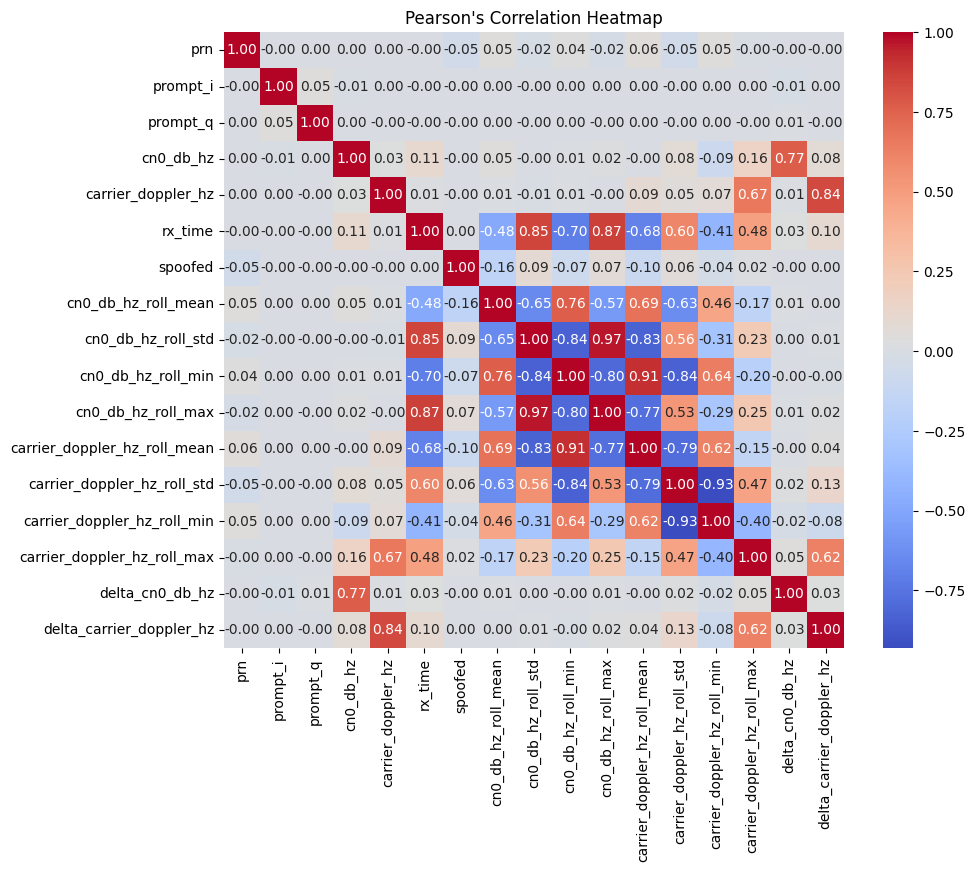

In [10]:
# Compute the correlation matrix
correlation_matrix = big_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [11]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 
           'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 
           'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
    tmp_path = os.path.join(base_path, ds_fname)
    key = ds_fname.split('.')[0]
    
    tmp_df = pd.read_csv(tmp_path, header=None)
    prn_li = []
    
    for i in range(8):
        prn_li.append(int(tmp_df.iloc[1, 11*i+1]))

    globals()[f'{key}_dict'] = {
        int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:11].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:22].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:33].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:44].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:55].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:66].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:77].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:88].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        'prn' : prn_li
    }


In [12]:
big_df_no_diff = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 2),
    (ds3_dict, 3),
    (ds4_dict, 4),
    (ds7_dict, 5),
    (ds8_dict, 6)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df_no_diff = dataset[prn].copy()
        df_no_diff['spoofed'] = label
        df_no_diff['prn'] = prn
        big_df_no_diff.append(df_no_diff)

big_df_no_diff = pd.concat(big_df_no_diff, ignore_index=True)
big_df_no_diff

,channel,prn,acq_doopler_hz,acq_doppler_step,fs,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time,spoofed
0,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
1,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
2,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
3,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
4,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
189267,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189268,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189269,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189270,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6


In [13]:
big_df_no_diff.drop(columns=['channel', 'fs', 'acq_doppler_step', 'pseudorange_m', 'acq_doopler_hz'], inplace=True)

In [14]:
no_extra = big_df_no_diff.copy()
no_extra

,prn,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,rx_time,spoofed
0,13,0.0,0.0000,0.000000,0.00000,0.0,0
1,13,0.0,0.0000,0.000000,0.00000,0.0,0
2,13,0.0,0.0000,0.000000,0.00000,0.0,0
3,13,0.0,0.0000,0.000000,0.00000,0.0,0
4,13,0.0,0.0000,0.000000,0.00000,0.0,0
...,...,...,...,...,...,...,...
189267,16,0.0,0.0000,0.000000,0.00000,0.0,6
189268,16,0.0,0.0000,0.000000,0.00000,0.0,6
189269,16,0.0,0.0000,0.000000,0.00000,0.0,6
189270,16,0.0,0.0000,0.000000,0.00000,0.0,6


In [15]:
# Calculate magnitude and phase
big_df['prompt_magnitude'] = np.sqrt(big_df['prompt_i']**2 + big_df['prompt_q']**2)
big_df['prompt_phase'] = np.arctan2(big_df['prompt_q'], big_df['prompt_i'])

# Calculate deltas (first-order difference)
big_df['delta_prompt_magnitude'] = big_df['prompt_magnitude'].diff().fillna(0)
big_df['delta_prompt_phase'] = big_df['prompt_phase'].diff().fillna(0)


In [16]:
# Calculate magnitude and phase
big_df_no_diff['prompt_magnitude'] = np.sqrt(big_df_no_diff['prompt_i']**2 + big_df_no_diff['prompt_q']**2)
big_df_no_diff['prompt_phase'] = np.arctan2(big_df_no_diff['prompt_q'], big_df_no_diff['prompt_i'])

# Calculate deltas (first-order difference)
big_df_no_diff['delta_prompt_magnitude'] = big_df_no_diff['prompt_magnitude'].diff().fillna(0)
big_df_no_diff['delta_prompt_phase'] = big_df_no_diff['prompt_phase'].diff().fillna(0)

# window_size = 200

big_df['prompt_magnitude_roll_mean'] = big_df['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')
big_df['prompt_magnitude_roll_std'] = big_df['prompt_magnitude'].rolling(window_size).std().fillna(0)

big_df_no_diff['prompt_magnitude_roll_mean'] = big_df_no_diff['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')
big_df_no_diff['prompt_magnitude_roll_std'] = big_df_no_diff['prompt_magnitude'].rolling(window_size).std().fillna(0)

/tmp/ipykernel_615721/4218134096.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  big_df['prompt_magnitude_roll_mean'] = big_df['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')
/tmp/ipykernel_615721/4218134096.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  big_df_no_diff['prompt_magnitude_roll_mean'] = big_df_no_diff['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')


In [17]:
# Sort by PRN and rx_time (in case it's not already)
big_df_no_diff = big_df_no_diff.sort_values(by=['prn', 'rx_time'])

# Define a rolling window size
# window_size = 200

# Apply rolling stats grouped by PRN
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df_no_diff[f'{col}_roll_mean'] = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    big_df_no_diff[f'{col}_roll_std']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
    big_df_no_diff[f'{col}_roll_min']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).min())
    big_df_no_diff[f'{col}_roll_max']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).max())

In [18]:
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df_no_diff[f'delta_{col}'] = big_df_no_diff.groupby('prn')[col].diff().fillna(0)


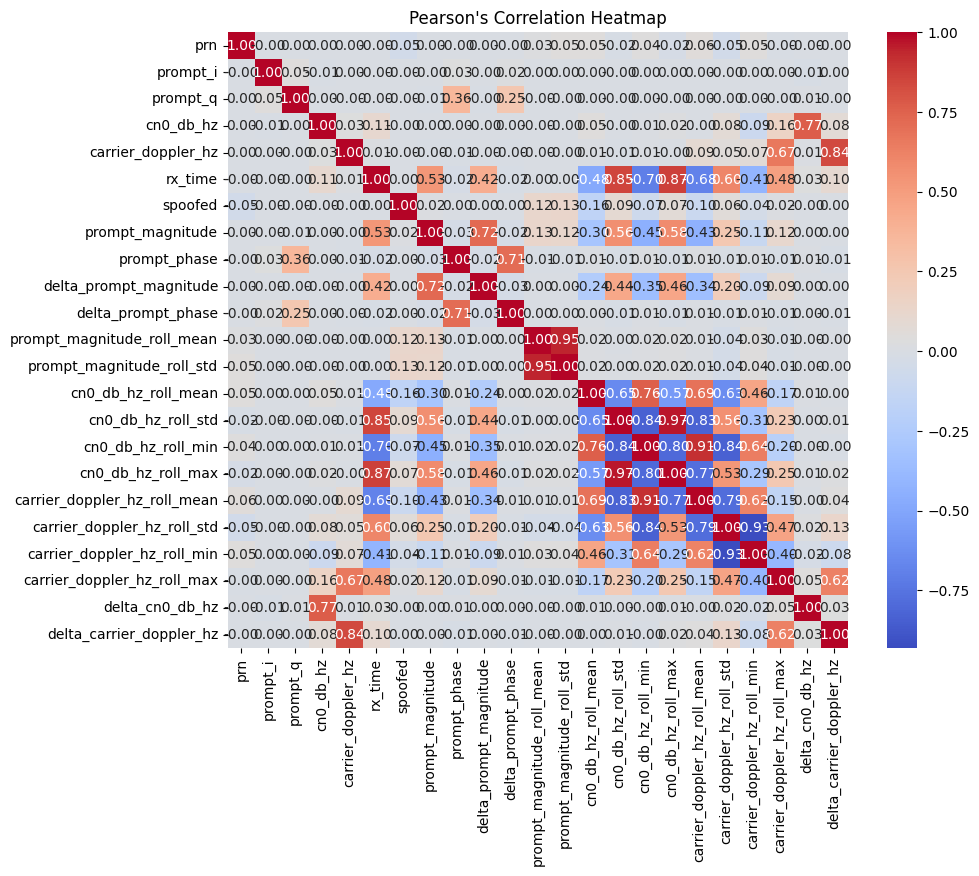

In [19]:
# Compute the correlation matrix
correlation_matrix_no_diff = big_df_no_diff.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_no_diff, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [20]:
big_df_no_diff.drop(columns=['prn'], inplace=True)
big_df.drop(columns=['prn'], inplace=True)

In [21]:
#scale data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(big_df.drop('spoofed', axis=1))

scaled_df = pd.DataFrame(scaled_df, columns=big_df.drop('spoofed', axis=1).columns)
scaled_df['spoofed'] = big_df['spoofed'].values


In [22]:
#scale data
scaler = StandardScaler()
scaled_df_no_diff = scaler.fit_transform(big_df_no_diff.drop('spoofed', axis=1))

scaled_df_no_diff = pd.DataFrame(scaled_df_no_diff, columns=big_df_no_diff.drop('spoofed', axis=1).columns)
scaled_df_no_diff['spoofed'] = big_df_no_diff['spoofed'].values

In [23]:
no_extra.drop(columns=['prn'], inplace=True)

In [24]:
scaler=StandardScaler()
scaled_df_no_extra = scaler.fit_transform(no_extra.drop('spoofed', axis=1))

scaled_df_no_extra = pd.DataFrame(scaled_df_no_extra, columns=no_extra.drop('spoofed', axis=1).columns)
scaled_df_no_extra['spoofed'] = no_extra['spoofed'].values

In [25]:
scaled_df.dropna(inplace=True)
scaled_df_no_diff.dropna(inplace=True)

In [295]:
# SVM with diff
X = scaled_df.drop(columns=['spoofed'])
y = scaled_df['spoofed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

X_no_diff = scaled_df_no_diff.drop(columns=['spoofed'])
y_no_diff = scaled_df_no_diff['spoofed']

X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff = train_test_split(X_no_diff, y_no_diff, test_size=0.2, shuffle=True)
X_train_no_diff, X_val_no_diff, y_train_no_diff, y_val_no_diff = train_test_split(X_train_no_diff, y_train_no_diff, test_size=0.2, shuffle=True)    

In [296]:
X_no_extra = scaled_df_no_diff.drop(columns=['spoofed'])
y_no_extra = scaled_df_no_diff['spoofed']
X_train_no_extra, X_test_no_extra, y_train_no_extra, y_test_no_extra = train_test_split(X_no_extra, y_no_extra, test_size=0.2, shuffle=True)
X_train_no_extra, X_val_no_extra, y_train_no_extra, y_val_no_extra = train_test_split(X_train_no_extra, y_train_no_extra, test_size=0.2, shuffle=True)


In [28]:
X_train.shape

(121127, 21)

In [29]:
X_train_no_diff

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,rx_time,prompt_magnitude,prompt_phase,delta_prompt_magnitude,delta_prompt_phase,prompt_magnitude_roll_mean,...,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,carrier_doppler_hz_roll_std,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max,delta_cn0_db_hz,delta_carrier_doppler_hz
56224,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-1.242073,-7.639487e-03,-0.643425,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
90627,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,2.086850,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
119594,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-4.062844,3.060099e+00,0.826273,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
153287,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.026318,-1.455069e+00,1.314527,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
45058,-0.003499,0.093410,1.520017,0.186135,2.356523,-0.219536,3.597024,0.002844,2.539504e+00,-1.610914,...,0.040015,2.047090,-1.279874,1.664986,-2.003393,0.809661,-0.161745,0.475351,1.108023,0.334718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111268,-4.382224,-0.501779,6.382190,0.093396,2.356523,4.265716,-4.323958,3.098005,-3.061390e+00,0.904875,...,-4.249823,3.797025,-2.536516,4.785259,-2.277486,0.963584,-0.307052,0.659919,7.848901,0.160899
20379,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,1.457142,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
11343,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-0.248281,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
15668,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,1.571880,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424


In [30]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

spoofed
6    0.147028
5    0.146986
1    0.144864
4    0.144295
2    0.142280
3    0.138219
0    0.136328
Name: proportion, dtype: float64
spoofed
1    0.146831
5    0.146620
6    0.144876
4    0.144823
2    0.142736
0    0.137162
3    0.136951
Name: proportion, dtype: float64


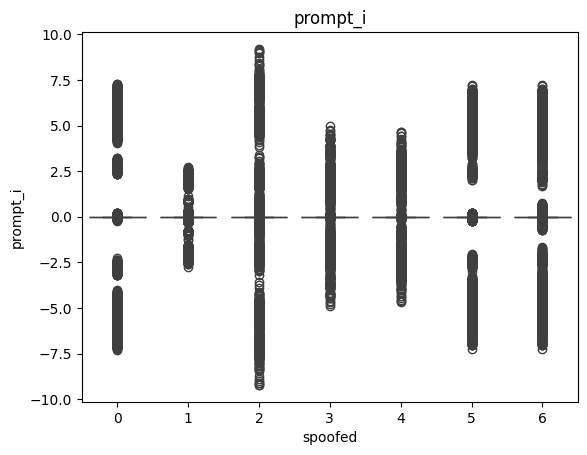

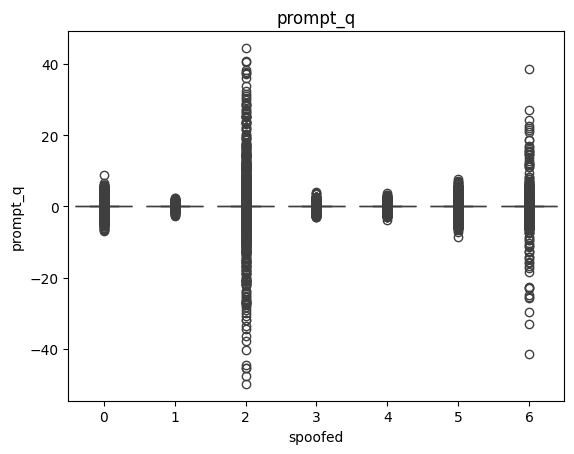

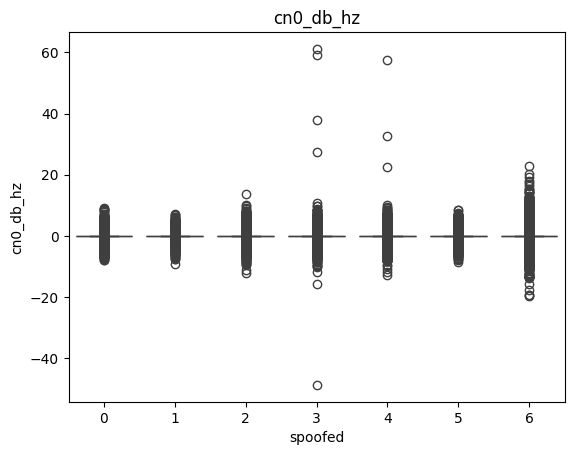

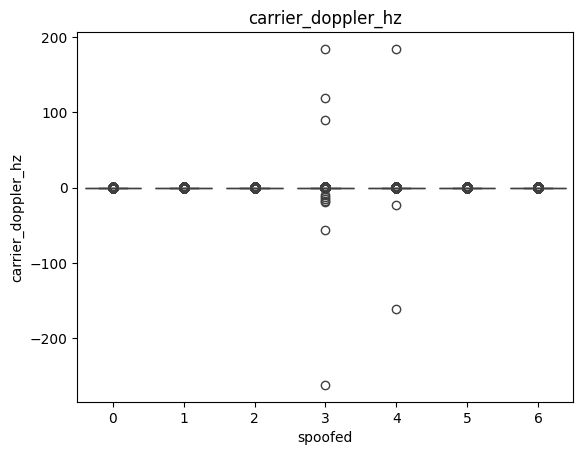

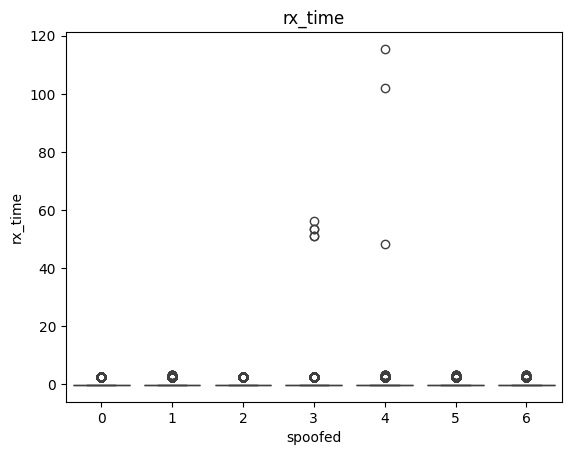

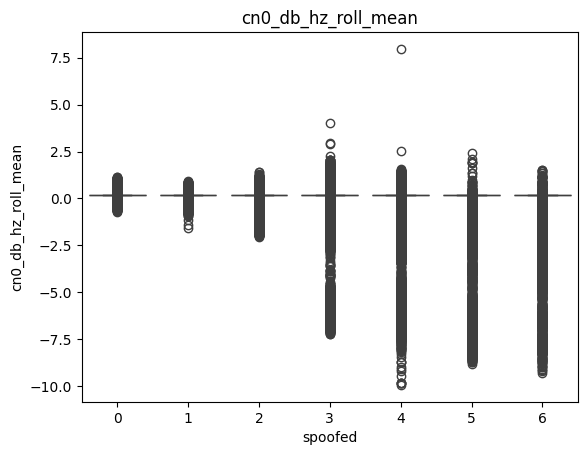

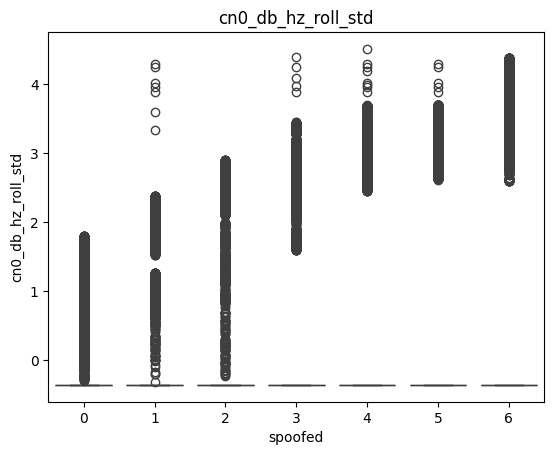

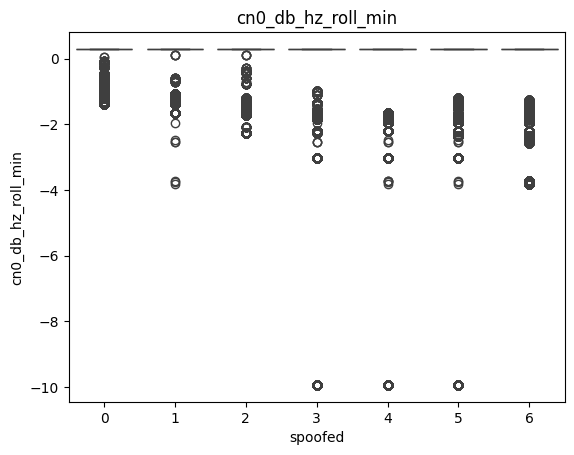

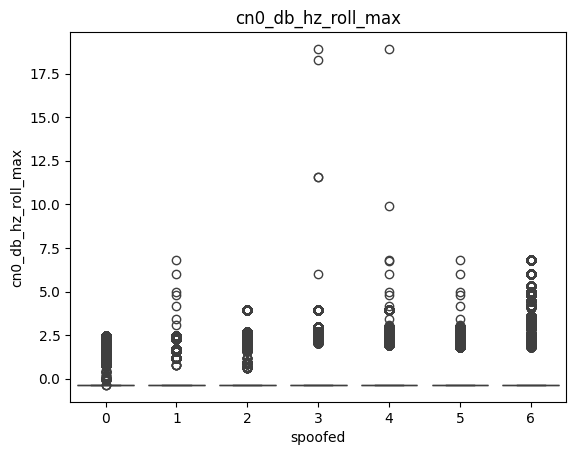

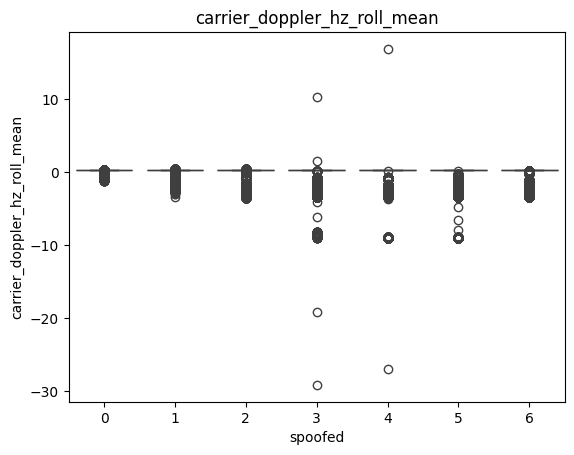

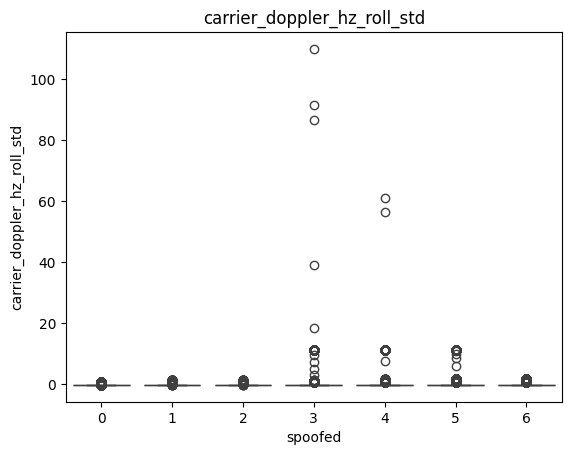

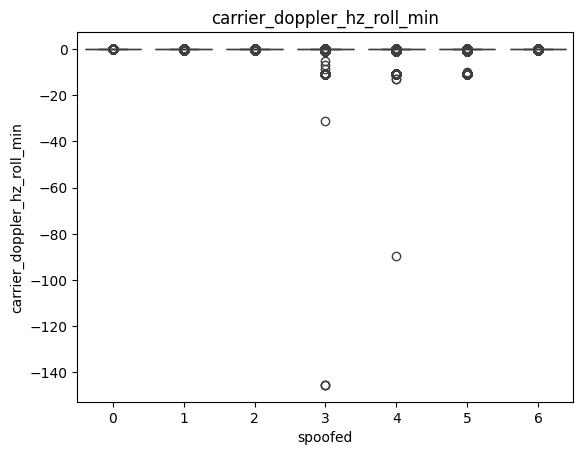

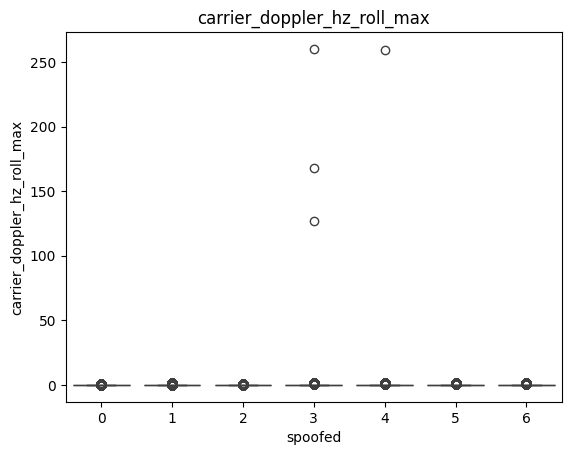

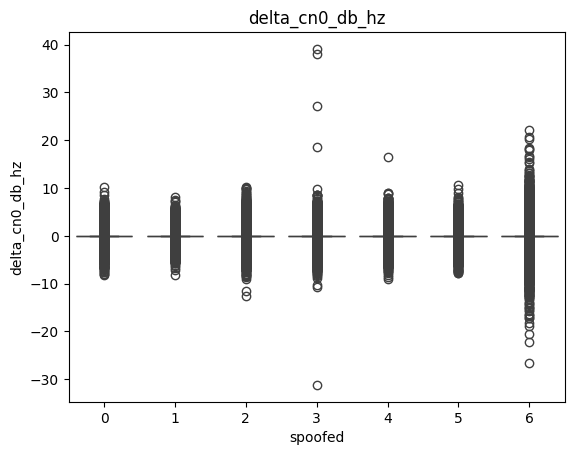

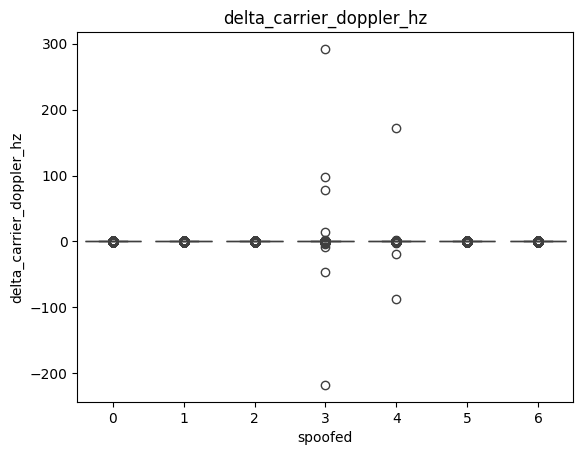

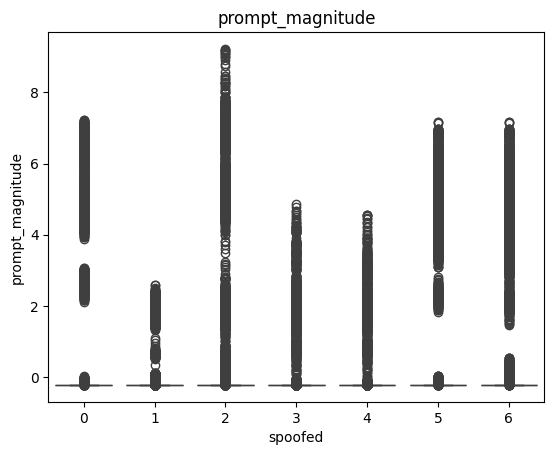

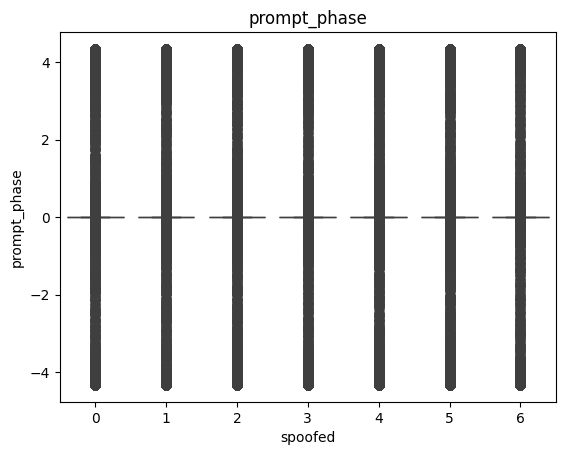

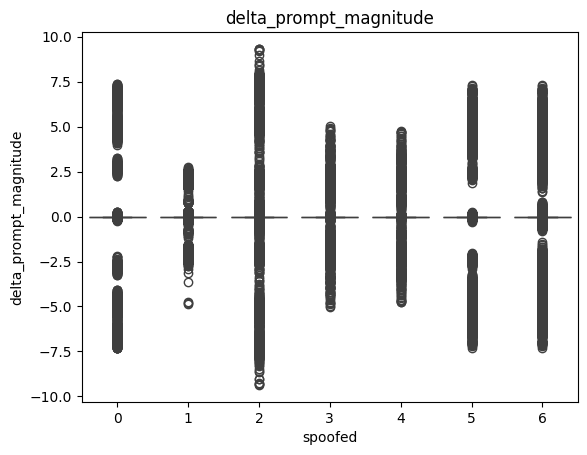

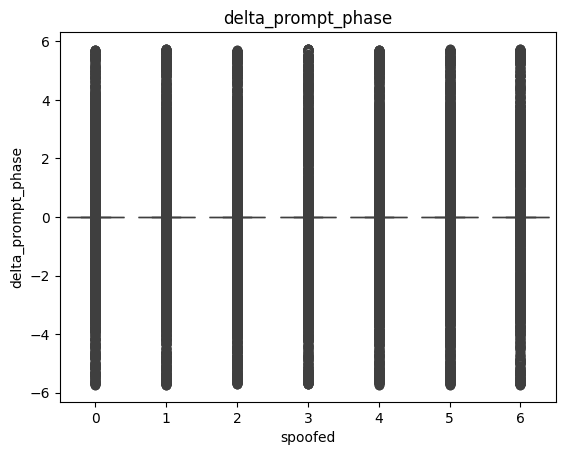

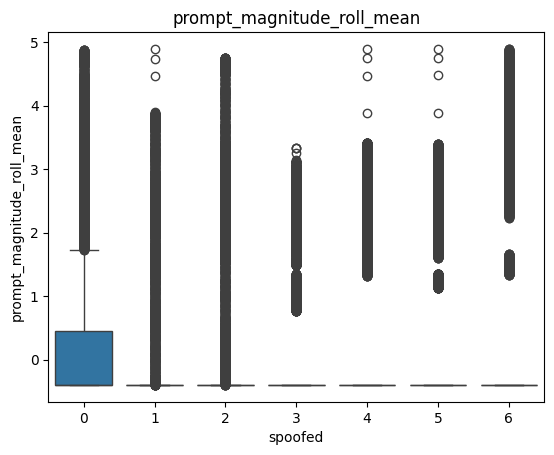

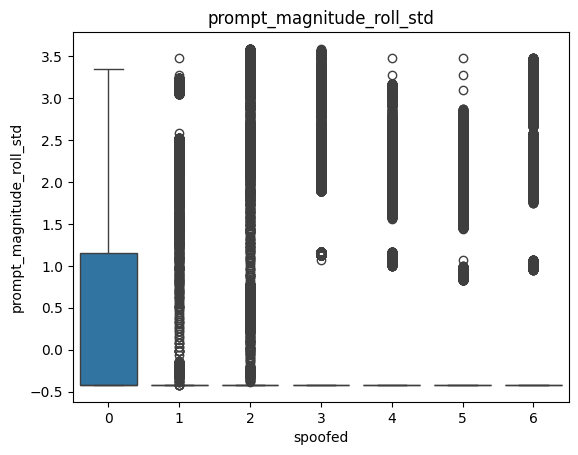

In [31]:
for col in X.columns:
    sns.boxplot(x=y, y=X[col])
    plt.title(col)
    plt.show()

In [32]:
scaled_df.corr()['spoofed'].abs().sort_values(ascending=False)

spoofed                         1.000000
cn0_db_hz_roll_mean             0.162110
prompt_magnitude_roll_std       0.121816
carrier_doppler_hz_roll_mean    0.096218
cn0_db_hz_roll_std              0.092799
cn0_db_hz_roll_min              0.072840
cn0_db_hz_roll_max              0.065931
carrier_doppler_hz_roll_std     0.060658
prompt_magnitude_roll_mean      0.045012
carrier_doppler_hz_roll_min     0.036163
carrier_doppler_hz_roll_max     0.019200
prompt_magnitude                0.017238
prompt_phase                    0.002158
cn0_db_hz                       0.000674
prompt_i                        0.000152
delta_carrier_doppler_hz        0.000144
delta_prompt_magnitude          0.000107
carrier_doppler_hz              0.000099
delta_prompt_phase              0.000065
prompt_q                        0.000049
delta_cn0_db_hz                 0.000037
rx_time                         0.000037
Name: spoofed, dtype: float64

In [33]:
scaled_df_no_diff.corr()['spoofed'].abs().sort_values(ascending=False)

spoofed                         1.000000
cn0_db_hz_roll_mean             0.162110
prompt_magnitude_roll_std       0.131029
prompt_magnitude_roll_mean      0.120500
carrier_doppler_hz_roll_mean    0.096218
cn0_db_hz_roll_std              0.092799
cn0_db_hz_roll_min              0.072840
cn0_db_hz_roll_max              0.065931
carrier_doppler_hz_roll_std     0.060658
carrier_doppler_hz_roll_min     0.036163
carrier_doppler_hz_roll_max     0.019200
prompt_magnitude                0.017238
prompt_phase                    0.002158
cn0_db_hz                       0.000674
prompt_i                        0.000152
delta_carrier_doppler_hz        0.000144
carrier_doppler_hz              0.000099
prompt_q                        0.000049
delta_cn0_db_hz                 0.000037
rx_time                         0.000037
delta_prompt_magnitude          0.000012
delta_prompt_phase              0.000008
Name: spoofed, dtype: float64

In [34]:
svm = SVC(kernel='rbf', C=1, class_weight='balanced')
#svm.fit(X_train, y_train)

In [35]:
svm_no_diff = SVC(kernel='rbf', C=1, class_weight='balanced')
#svm_no_diff.fit(X_train_no_diff, y_train_no_diff)

In [36]:
#PCA for SVM
pca = PCA(n_components=.95)
X_pca = pca.fit_transform(X)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, shuffle=True)
X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(X_train_pca, y_train_pca, test_size=0.2, shuffle=True)

X_no_diff_pca = pca.fit_transform(X_no_diff)
X_train_no_diff_pca, X_test_no_diff_pca, y_train_no_diff_pca, y_test_no_diff_pca = train_test_split(X_no_diff_pca, y_no_diff, test_size=0.2, shuffle=True)
X_train_no_diff_pca, X_val_no_diff_pca, y_train_no_diff_pca, y_val_no_diff_pca = train_test_split(X_train_no_diff_pca, y_train_no_diff_pca, test_size=0.2, shuffle=True)

In [37]:
svm_pca = SVC(kernel='rbf', C=1, class_weight='balanced')
#svm_pca.fit(X_train_pca, y_train_pca)

In [38]:
svm_no_diff_pca = SVC(kernel='rbf', C=1, class_weight='balanced')
#svm_no_diff_pca.fit(X_train_no_diff_pca, y_train_no_diff_pca)

In [39]:
#y_pred = svm.predict(X_test)

In [40]:
#y_pred_no_diff = svm_no_diff.predict(X_test_no_diff)

In [41]:
#y_pred_pca = svm_pca.predict(X_test_pca)

In [42]:
#y_pred_no_diff_pca = svm_no_diff_pca.predict(X_test_no_diff_pca)

In [43]:
""" print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show() """

" print(classification_report(y_test, y_pred))\ncm = confusion_matrix(y_test, y_pred)\nplt.figure(figsize=(10, 8))\nsns.heatmap(cm, annot=True, fmt='d', cmap='Blues')\nplt.title('Confusion Matrix')\nplt.xlabel('Predicted Label')\nplt.ylabel('True Label')\nplt.show() "

In [44]:
""" print(classification_report(y_test_no_diff, y_pred_no_diff))
cm_no_diff = confusion_matrix(y_test_no_diff, y_pred_no_diff)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label') """

" print(classification_report(y_test_no_diff, y_pred_no_diff))\ncm_no_diff = confusion_matrix(y_test_no_diff, y_pred_no_diff)\nplt.figure(figsize=(10, 8))\nsns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')\nplt.title('Confusion Matrix (No Diff)')\nplt.xlabel('Predicted Label')\nplt.ylabel('True Label') "

In [45]:
""" print(classification_report(y_test_pca, y_pred_pca))
cm_pca = confusion_matrix(y_test_pca, y_pred_pca)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('PCA Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label') """

" print(classification_report(y_test_pca, y_pred_pca))\ncm_pca = confusion_matrix(y_test_pca, y_pred_pca)\nplt.figure(figsize=(10, 8))\nsns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')\nplt.title('PCA Confusion Matrix')\nplt.xlabel('Predicted Label')\nplt.ylabel('True Label') "

In [46]:
""" print(classification_report(y_test_no_diff_pca, y_pred_no_diff_pca))
cm_pca_no_diff = confusion_matrix(y_test_no_diff_pca, y_pred_no_diff_pca)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('PCA Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label') """

" print(classification_report(y_test_no_diff_pca, y_pred_no_diff_pca))\ncm_pca_no_diff = confusion_matrix(y_test_no_diff_pca, y_pred_no_diff_pca)\nplt.figure(figsize=(10, 8))\nsns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')\nplt.title('PCA Confusion Matrix (No Diff)')\nplt.xlabel('Predicted Label')\nplt.ylabel('True Label') "

In [47]:
#random forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=12)
rf_model.fit(X_train, y_train)

rf_model_no_diff = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=12)
rf_model_no_diff.fit(X_train_no_diff, y_train_no_diff)

print("Random Forest")

importances = rf_model.feature_importances_
features = X_train.columns  # assuming 'spoofed' is last
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")

print("\nRandom Forest No Diff")

importances = rf_model_no_diff.feature_importances_
features = X_train.columns  # assuming 'spoofed' is last
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")

Random Forest
prompt_i: 0.0072
prompt_q: 0.0064
cn0_db_hz: 0.0007
carrier_doppler_hz: 0.0012
rx_time: 0.0032
cn0_db_hz_roll_mean: 0.0339
cn0_db_hz_roll_std: 0.1446
cn0_db_hz_roll_min: 0.0821
cn0_db_hz_roll_max: 0.0667
carrier_doppler_hz_roll_mean: 0.0502
carrier_doppler_hz_roll_std: 0.0991
carrier_doppler_hz_roll_min: 0.0622
carrier_doppler_hz_roll_max: 0.0607
delta_cn0_db_hz: 0.0008
delta_carrier_doppler_hz: 0.0008
prompt_magnitude: 0.0393
prompt_phase: 0.0010
delta_prompt_magnitude: 0.0152
delta_prompt_phase: 0.0005
prompt_magnitude_roll_mean: 0.1509
prompt_magnitude_roll_std: 0.1737

Random Forest No Diff
prompt_i: 0.0007
prompt_q: 0.0007
cn0_db_hz: 0.0004
carrier_doppler_hz: 0.0004
rx_time: 0.0041
cn0_db_hz_roll_mean: 0.0068
cn0_db_hz_roll_std: 0.0002
cn0_db_hz_roll_min: 0.0194
cn0_db_hz_roll_max: 0.0043
carrier_doppler_hz_roll_mean: 0.3878
carrier_doppler_hz_roll_std: 0.3767
carrier_doppler_hz_roll_min: 0.0131
carrier_doppler_hz_roll_max: 0.0476
delta_cn0_db_hz: 0.0257
delta_carri

In [48]:
y_pred = rf_model.predict(X_test)
y_pred_no_diff = rf_model_no_diff.predict(X_test_no_diff)

              precision    recall  f1-score   support

           0       0.88      0.39      0.54      5192
           1       1.00      0.13      0.23      5558
           2       0.99      0.14      0.24      5403
           3       1.00      0.12      0.21      5184
           4       0.17      1.00      0.29      5482
           5       1.00      0.13      0.22      5550
           6       1.00      0.13      0.23      5484

    accuracy                           0.29     37853
   macro avg       0.86      0.29      0.28     37853
weighted avg       0.86      0.29      0.28     37853



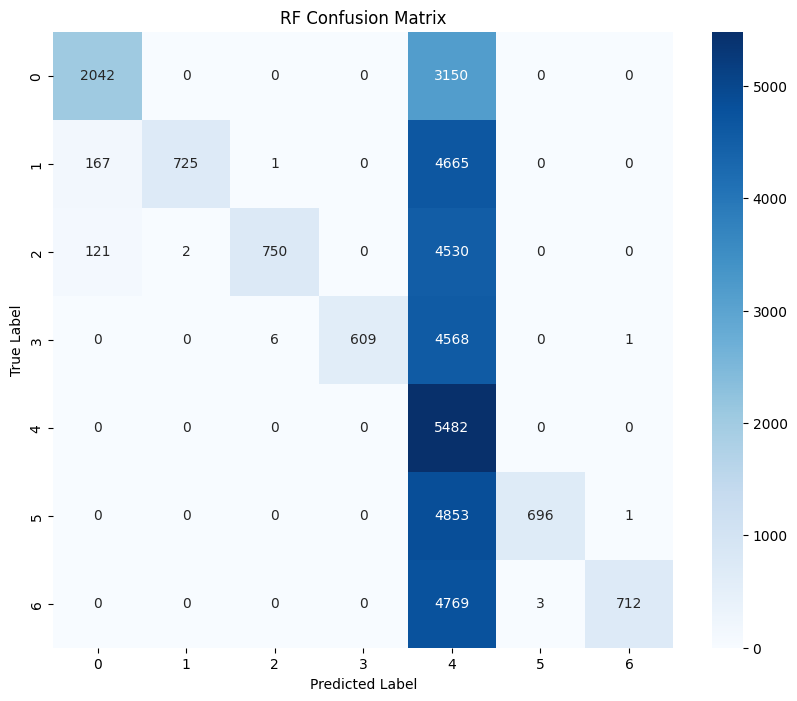

In [49]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('RF Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.61      0.75      0.67      5199
           1       0.84      0.85      0.85      5455
           2       0.73      0.67      0.70      5381
           3       0.69      0.70      0.69      5212
           4       0.59      0.76      0.67      5315
           5       0.54      0.52      0.53      5615
           6       0.71      0.45      0.55      5676

    accuracy                           0.67     37853
   macro avg       0.67      0.67      0.66     37853
weighted avg       0.67      0.67      0.66     37853



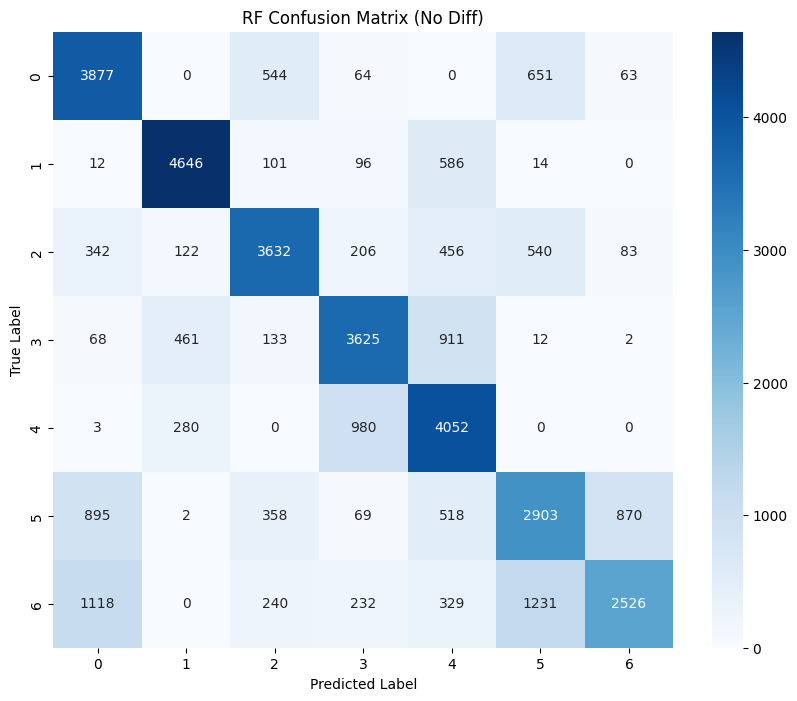

In [50]:
print(classification_report(y_test_no_diff, y_pred_no_diff))
cm = confusion_matrix(y_test_no_diff, y_pred_no_diff)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('RF Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

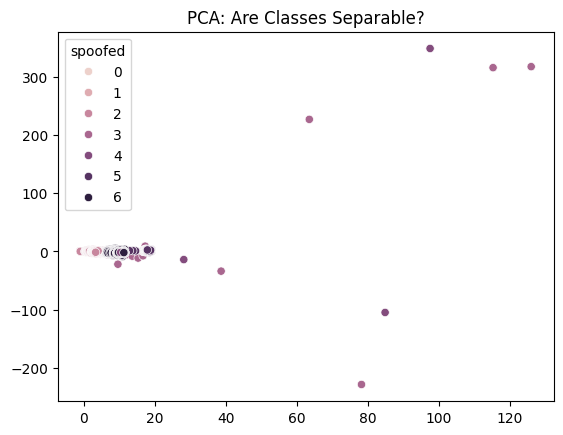

In [51]:
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y)
plt.title("PCA: Are Classes Separable?")
plt.show()

In [52]:
# Hybrid XGBoost + Deep Feature Synthesis for real-time deployment.
# Implementation Framework
# python
# Preprocessing Pipeline
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
 
preprocessor = Pipeline([
#  ('feature_extractor', GPSFeatureEngineer()),
   ('imputer', KNNImputer(n_neighbors=5)),
#   ('smote', SMOTE(sampling_strategy='minority')),
   ('scaler', RobustScaler())
])
 
# XGBoost Classifier
import xgboost as xgb
xgboost_model = xgb.XGBClassifier(
  objective='binary:logistic',
  tree_method='hist',
   n_estimators=300,
   max_depth=9,
  learning_rate=0.05,
   subsample=0.8,
  colsample_bytree=0.9
)
 
# Real-Time Inference
def detect_spoofing(sample_window):
   processed = preprocessor.transform(sample_window)
   proba = xgboost_model.predict_proba(processed)[:,1]
   return (proba > 0.92).astype(int)  # Optimized threshold

X_processed = preprocessor.fit_transform(X_train)

smote = SMOTE(sampling_strategy='minority')

X_resampled, y_resampled = smote.fit_resample(X_processed, y_train)

xgboost_model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [53]:
X_test_processed = preprocessor.transform(X_test)
y_pred = xgboost_model.predict(X_test_processed)

In [54]:
param_grid = {
    'max_depth': [20],
    'learning_rate': [0.1],
    'n_estimators': [500, 550, 600, 650],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0]
}

In [55]:
X_train_no_diff_processed = preprocessor.fit_transform(X_train_no_diff)
smote_no_diff = SMOTE(sampling_strategy='minority')
X_resampled_no_diff, y_resampled_no_diff = smote_no_diff.fit_resample(X_train_no_diff_processed, y_train_no_diff)

xgboost_model_no_diff = xgb.XGBClassifier(
  objective='multi:softprob',
  num_class=7,
  tree_method='hist',
  n_estimators=300,
  max_depth=9,
  learning_rate=0.05,
  subsample=0.8,
  colsample_bytree=0.9,
  use_label_encoder=False,
  eval_metric='mlogloss'
)

xgboost_model_no_diff.fit(X_resampled_no_diff, y_resampled_no_diff)

/home/nicholastey/gnss_spoof_detector/ipynb/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:31:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, num_class=7, ...)

In [56]:
grid_search = GridSearchCV(
    xgboost_model_no_diff,
    param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_resampled_no_diff, y_resampled_no_diff)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/home/nicholastey/gnss_spoof_detector/ipynb/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:31:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nicholastey/gnss_spoof_detector/ipynb/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:31:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nicholastey/gnss_spoof_detector/ipynb/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:31:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nicholastey/gnss_spoof_detector/ipynb/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [10:31:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 550, 'subsample': 0.8}
Best Score: 0.8607801373943275


In [59]:
X_test_no_diff_processed = preprocessor.transform(X_test_no_diff)
y_pred_no_diff = xgboost_model_no_diff.predict(X_test_no_diff_processed)

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5199
           1       0.92      0.92      0.92      5455
           2       0.91      0.88      0.90      5381
           3       0.84      0.85      0.85      5212
           4       0.85      0.86      0.86      5315
           5       0.81      0.81      0.81      5615
           6       0.84      0.81      0.82      5676

    accuracy                           0.86     37853
   macro avg       0.86      0.86      0.86     37853
weighted avg       0.86      0.86      0.86     37853



Text(95.72222222222221, 0.5, 'True Label')

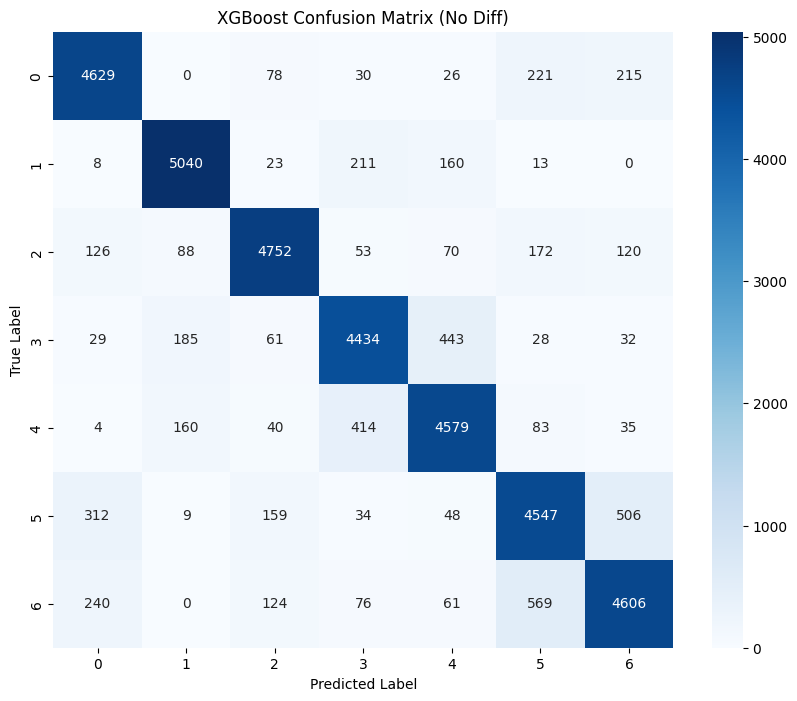

In [60]:
y_pred_best = best_model.predict(X_test_no_diff_processed)
print(classification_report(y_test_no_diff, y_pred_best))
cm_best = confusion_matrix(y_test_no_diff, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


              precision    recall  f1-score   support

           0       0.97      0.39      0.55      5192
           1       0.99      0.15      0.26      5558
           2       0.99      0.16      0.27      5403
           3       1.00      0.12      0.21      5184
           4       0.99      0.12      0.22      5482
           5       1.00      0.13      0.22      5550
           6       0.17      1.00      0.29      5484

    accuracy                           0.30     37853
   macro avg       0.87      0.29      0.29     37853
weighted avg       0.87      0.30      0.29     37853



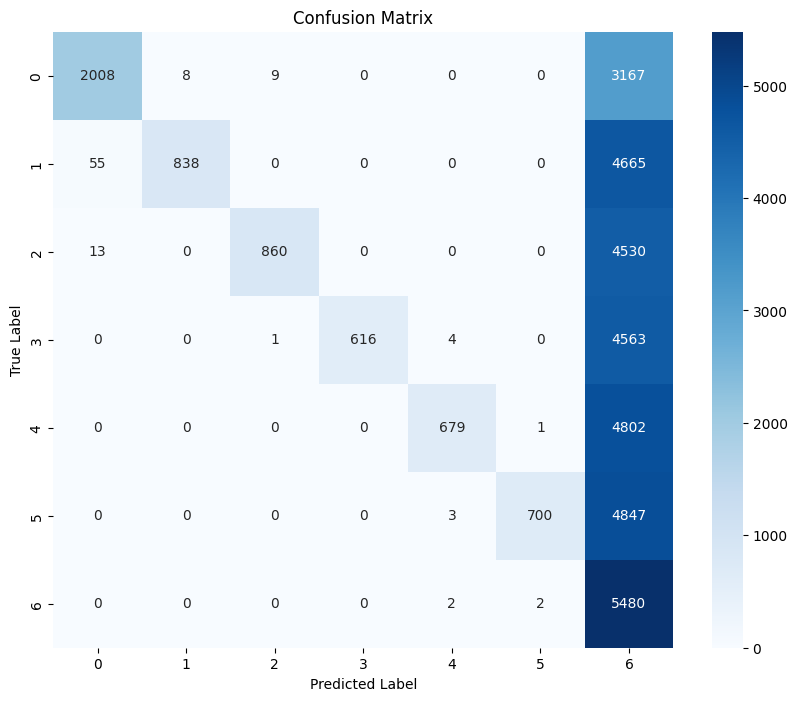

In [61]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      5199
           1       0.91      0.92      0.91      5455
           2       0.87      0.85      0.86      5381
           3       0.82      0.83      0.82      5212
           4       0.82      0.82      0.82      5315
           5       0.72      0.75      0.73      5615
           6       0.79      0.74      0.76      5676

    accuracy                           0.82     37853
   macro avg       0.82      0.82      0.82     37853
weighted avg       0.82      0.82      0.82     37853



Text(95.72222222222221, 0.5, 'True Label')

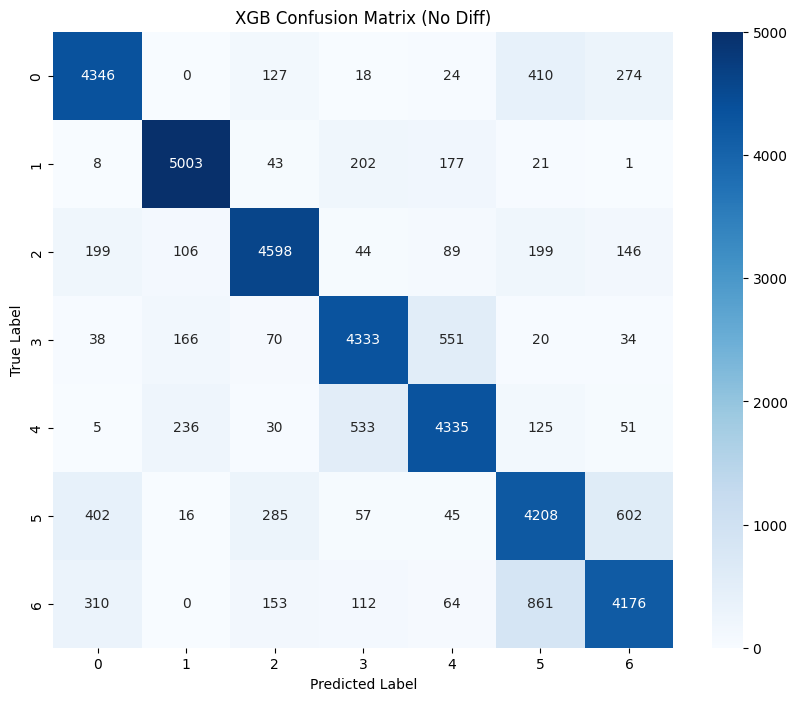

In [62]:
print(classification_report(y_test_no_diff, y_pred_no_diff))
cm_no_diff = confusion_matrix(y_test_no_diff, y_pred_no_diff)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('XGB Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [63]:
X_val_no_diff_processed = preprocessor.transform(X_val_no_diff)
y_val_no_diff_pred = xgboost_model_no_diff.predict(X_val_no_diff_processed)

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      4139
           1       0.91      0.92      0.91      4357
           2       0.87      0.86      0.86      4350
           3       0.81      0.84      0.82      4232
           4       0.83      0.81      0.82      4360
           5       0.71      0.74      0.73      4302
           6       0.79      0.74      0.77      4542

    accuracy                           0.82     30282
   macro avg       0.82      0.82      0.82     30282
weighted avg       0.82      0.82      0.82     30282



Text(95.72222222222221, 0.5, 'True Label')

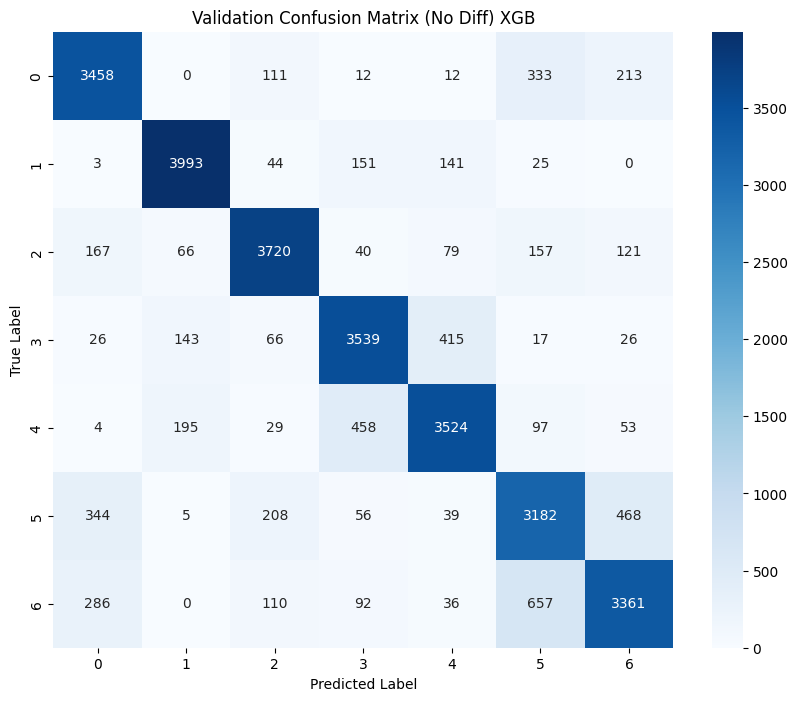

In [64]:
print(classification_report(y_val_no_diff, y_val_no_diff_pred))
cm_val_no_diff = confusion_matrix(y_val_no_diff, y_val_no_diff_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (No Diff) XGB')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [65]:
y_val_no_diff_pred = rf_model_no_diff.predict(X_val_no_diff)

              precision    recall  f1-score   support

           0       0.61      0.74      0.67      4139
           1       0.84      0.84      0.84      4357
           2       0.72      0.67      0.69      4350
           3       0.68      0.71      0.69      4232
           4       0.60      0.76      0.67      4360
           5       0.52      0.50      0.51      4302
           6       0.73      0.44      0.55      4542

    accuracy                           0.67     30282
   macro avg       0.67      0.67      0.66     30282
weighted avg       0.67      0.67      0.66     30282



Text(95.72222222222221, 0.5, 'True Label')

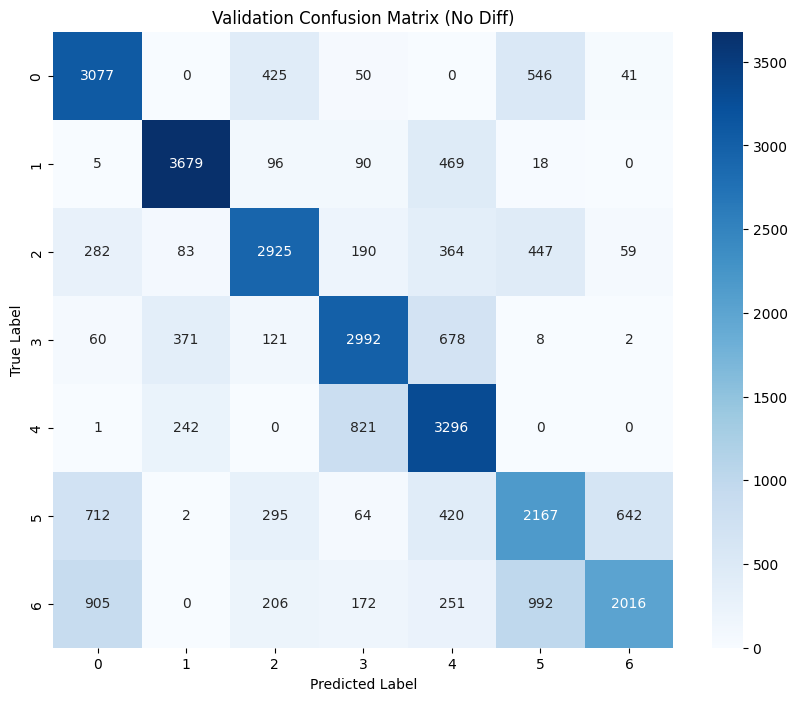

In [66]:
print(classification_report(y_val_no_diff, y_val_no_diff_pred))
cm_val_no_diff = confusion_matrix(y_val_no_diff, y_val_no_diff_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [67]:
# LSTM
#sense change then apply classifier
# change point detection
#time feature

In [68]:
X.tail()

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,rx_time,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,...,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max,delta_cn0_db_hz,delta_carrier_doppler_hz,prompt_magnitude,prompt_phase,delta_prompt_magnitude,delta_prompt_phase,prompt_magnitude_roll_mean,prompt_magnitude_roll_std
189267,-2.284026,1.423171,2.510257,-0.062058,2.356523,0.620215,1.982086,-2.0718,2.253714,0.332126,...,-0.303703,0.669603,2.516705,-0.116698,2.116409,4.319505,2.280062,0.644334,0.480095,0.780430
189268,0.080446,-3.010753,1.348353,0.242437,2.356523,0.709436,1.982756,-2.0718,2.253714,0.358989,...,-0.303703,0.669603,-0.766871,0.251759,-0.116460,-0.951330,-2.222062,-3.493984,0.480287,0.780363
189269,-0.050734,2.344040,-1.145022,-0.164687,2.356523,0.633488,1.983252,-2.0718,2.253714,0.340257,...,-0.303703,0.669603,-1.644950,-0.339941,-0.149199,3.236715,-0.032580,2.776189,0.480421,0.780315
189270,2.277118,-1.628454,3.023877,-0.040324,2.356523,0.833701,1.986638,-2.0718,2.253714,0.335453,...,-0.303703,0.669603,2.748689,0.101982,2.109447,-0.016357,2.247714,-2.156434,0.484601,0.782569
189271,-0.030007,0.386278,-5.098835,-0.065308,2.356523,0.495839,1.996330,-2.0718,2.253714,0.327851,...,-0.303703,0.669603,-5.357388,-0.022197,-0.191731,3.954077,-2.290040,2.631936,0.484658,0.782547


In [301]:
import pywt

def apply_wavelet_per_sequence(X_seq, wavelet='db4', level=2):

    X_wavelet = []

    for sequence in X_seq:  # shape: (time_steps, features)
        features = []
        for i in range(sequence.shape[1]):  # for each feature
            coeffs = pywt.wavedec(sequence[:, i], wavelet=wavelet, level=level)
            features.extend(np.concatenate(coeffs))  # flatten all coeffs
        X_wavelet.append(features)

    return np.array(X_wavelet)


In [302]:
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:i + time_steps].values)
        ys.append(y.iloc[i + time_steps])  # label is at end of window
    return np.array(Xs), np.array(ys)


In [303]:
from sklearn.utils import shuffle

time_steps = 50
X_seq, y_seq = create_sequences(X, y, time_steps=time_steps)
X_seq_no_diff, y_seq_no_diff = create_sequences(X_no_diff, y_no_diff, time_steps=time_steps)
X_seq_no_extra, y_seq_no_extra = create_sequences(X_no_extra, y_no_extra, time_steps=time_steps)

X_seq_wavelet = apply_wavelet_per_sequence(X_seq)
X_seq_no_diff_wavelet = apply_wavelet_per_sequence(X_seq_no_diff)
X_seq__no_extra_wavelet = apply_wavelet_per_sequence(X_seq_no_extra)


X_seq, y_seq = shuffle(X_seq, y_seq, random_state=42)
X_seq_no_diff, y_seq_no_diff = shuffle(X_seq_no_diff, y_seq_no_diff, random_state=42)
X_seq_no_extra, y_seq_no_extra = shuffle(X_seq_no_extra, y_seq_no_extra, random_state=42)

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42
)
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(
    X_train_lstm, y_train_lstm, test_size=0.2, stratify=y_train_lstm, random_state=42
)

X_train_no_diff_lstm, X_test_no_diff_lstm, y_train_no_diff_lstm, y_test_no_diff_lstm = train_test_split(
    X_seq_no_diff, y_seq_no_diff, test_size=0.2, stratify=y_seq_no_diff, random_state=42
)
X_train_no_diff_lstm, X_val_no_diff_lstm, y_train_no_diff_lstm, y_val_no_diff_lstm = train_test_split(
    X_train_no_diff_lstm, y_train_no_diff_lstm, test_size=0.2, stratify=y_train_no_diff_lstm, random_state=42
)

X_train_no_extra_lstm, X_test_no_extra_lstm, y_train_no_extra_lstm, y_test_no_extra_lstm = train_test_split(
    X_seq_no_extra, y_seq_no_extra, test_size=0.2, stratify=y_seq_no_extra, random_state=42
)
X_train_no_extra_lstm, X_val_no_extra_lstm, y_train_no_extra_lstm, y_val_no_extra_lstm = train_test_split(
    X_train_no_extra_lstm, y_train_no_extra_lstm, test_size=0.2, stratify=y_train_no_extra_lstm, random_state=42
)

In [304]:
""" time_steps = 250

# Reshape data for LSTM
X_train_lstm = create_sequences(X_train.values, time_steps)
y_train_lstm = y_train.values[time_steps:]  # Adjust labels accordingly
X_test_lstm = create_sequences(X_test.values, time_steps)
y_test_lstm = y_test.values[time_steps:]  # Adjust labels accordingly
X_val_lstm = create_sequences(X_val.values, time_steps)
y_val_lstm = y_val.values[time_steps:]  # Adjust labels accordingly

X_train_no_diff_lstm = create_sequences(X_train_no_diff.values, time_steps)
y_train_no_diff_lstm = y_train_no_diff.values[time_steps:]  # Adjust labels accordingly
X_test_no_diff_lstm = create_sequences(X_test_no_diff.values, time_steps)
y_test_no_diff_lstm = y_test_no_diff.values[time_steps:]  # Adjust labels accordingly
X_val_no_diff_lstm = create_sequences(X_val_no_diff.values, time_steps)
y_val_no_diff_lstm = y_val_no_diff.values[time_steps:]  # Adjust labels accordingly

X_train_no_extra_lstm = create_sequences(X_train_no_extra.values, time_steps)
y_train_no_extra_lstm = y_train_no_extra.values[time_steps:]  # Adjust labels accordingly
X_test_no_extra_lstm = create_sequences(X_test_no_extra.values, time_steps)
y_test_no_extra_lstm = y_test_no_extra.values[time_steps:]  # Adjust labels accordingly
X_val_no_extra_lstm = create_sequences(X_val_no_extra.values, time_steps)
y_val_no_extra_lstm = y_val_no_extra.values[time_steps:]  # Adjust labels accordingly """

' time_steps = 250\n\n# Reshape data for LSTM\nX_train_lstm = create_sequences(X_train.values, time_steps)\ny_train_lstm = y_train.values[time_steps:]  # Adjust labels accordingly\nX_test_lstm = create_sequences(X_test.values, time_steps)\ny_test_lstm = y_test.values[time_steps:]  # Adjust labels accordingly\nX_val_lstm = create_sequences(X_val.values, time_steps)\ny_val_lstm = y_val.values[time_steps:]  # Adjust labels accordingly\n\nX_train_no_diff_lstm = create_sequences(X_train_no_diff.values, time_steps)\ny_train_no_diff_lstm = y_train_no_diff.values[time_steps:]  # Adjust labels accordingly\nX_test_no_diff_lstm = create_sequences(X_test_no_diff.values, time_steps)\ny_test_no_diff_lstm = y_test_no_diff.values[time_steps:]  # Adjust labels accordingly\nX_val_no_diff_lstm = create_sequences(X_val_no_diff.values, time_steps)\ny_val_no_diff_lstm = y_val_no_diff.values[time_steps:]  # Adjust labels accordingly\n\nX_train_no_extra_lstm = create_sequences(X_train_no_extra.values, time_st

In [305]:
X_train_lstm.shape

(121095, 50, 21)

In [306]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Bidirectional, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

def create_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)  # Increased dropout
    x = LSTM(25, return_sequences=False)(x)
    x = Dropout(0.3)(x)  # Increased dropout
    x = Dense(25, activation='relu')(x)
    x = Dropout(0.3)(x)  # Increased dropout
    x = Dense(12, activation='relu')(x)
    x = BatchNormalization()(x)  # Batch Normalization
    outputs = Dense(7, activation='softmax')(x)

    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=0.01)  # Lower learning rate
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


In [307]:
lstm_model = create_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))

In [308]:
# Train LSTM model
lstm_model.fit(X_train_lstm, y_train_lstm, 
               validation_data=(X_val_lstm, y_val_lstm), 
               epochs=1, 
               batch_size=500, 
               verbose=1, 
               callbacks=[lr_schedule])


243/243 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.2069 - loss: 1.8639 - val_accuracy: 0.2308 - val_loss: 1.7615 - learning_rate: 0.0100


1183/1183 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2317 - loss: 1.7609
LSTM Test Loss: 1.7633, Test Accuracy: 0.2301
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
              precision    recall  f1-score   support

           0       0.79      0.31      0.45      5168
           1       0.16      0.96      0.28      5499
           2       0.79      0.10      0.18      5378
           3       0.60      0.01      0.01      5224
           4       0.55      0.09      0.16      5448
           5       0.84      0.01      0.02      5563
           6       0.46      0.12      0.19      5563

    accuracy                           0.23     37843
   macro avg       0.60      0.23      0.18     37843
weighted avg       0.60      0.23      0.18     37843



Text(95.72222222222221, 0.5, 'True Label')

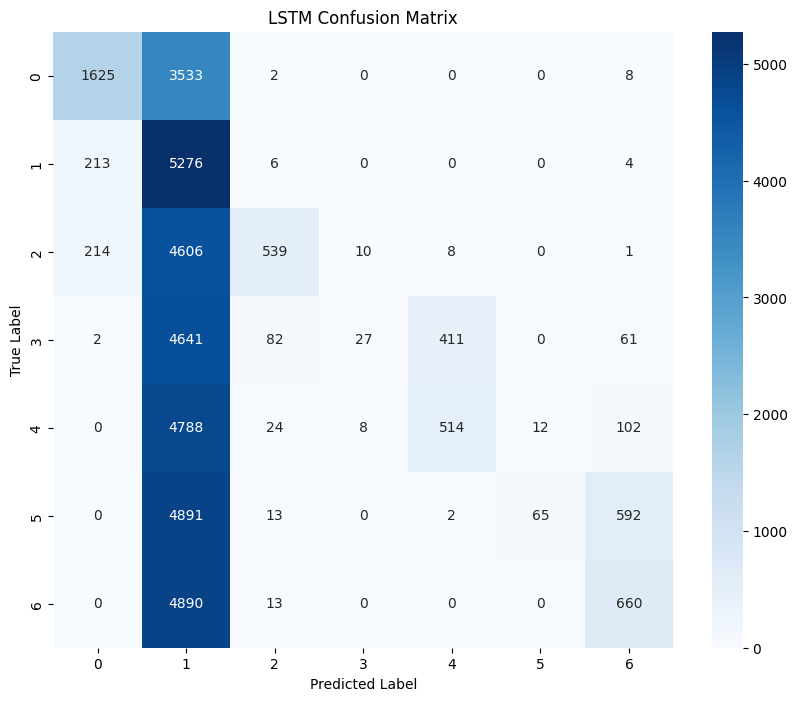

In [309]:
# Evaluate LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test_lstm, verbose=1)
print(f"LSTM Test Loss: {lstm_loss:.4f}, Test Accuracy: {lstm_accuracy:.4f}")
y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
print(classification_report(y_test_lstm, y_pred_lstm))
cm_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


In [310]:
lstm_model_no_diff = create_lstm_model((X_train_no_diff_lstm.shape[1], X_train_no_diff_lstm.shape[2]))
lstm_model_no_diff.summary()

# Train LSTM model
lstm_model_no_diff.fit(X_train_no_diff_lstm, y_train_no_diff_lstm, 
               validation_data=(X_val_no_diff_lstm, y_val_no_diff_lstm), 
               epochs=35, 
               batch_size=500, 
               verbose=1,
               callbacks=[lr_schedule])


Model: "functional_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_62 (InputLayer)     │ (None, 50, 21)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 50, 64)         │        22,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 25)             │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 25)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 12)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 7)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,117 (125.46 KB)

 Trainable params: 32,093 (125.36 KB)

 Non-trainable params: 24 (96.00 B)

Epoch 1/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.4072 - loss: 1.4248 - val_accuracy: 0.5091 - val_loss: 1.1481 - learning_rate: 0.0100
Epoch 2/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.5244 - loss: 1.1143 - val_accuracy: 0.5548 - val_loss: 0.9768 - learning_rate: 0.0100
Epoch 3/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.5496 - loss: 1.0235 - val_accuracy: 0.5561 - val_loss: 0.9936 - learning_rate: 0.0100
Epoch 4/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.5555 - loss: 1.0113 - val_accuracy: 0.5508 - val_loss: 0.9949 - learning_rate: 0.0100
Epoch 5/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.5694 - loss: 0.9755 - val_accuracy: 0.5782 - val_loss: 0.9208 - learning_rate: 0.0100
Epoch 6/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.5850 - loss: 0.9337 - val_accuracy: 0.6255 - val_loss: 0.8176 - learning_rate: 0.0100
Epoch 7/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.6132 - l

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9011 - loss: 0.2550
LSTM Test Loss: 0.2535, Test Accuracy: 0.9016
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      5168
           1       0.95      0.96      0.96      5499
           2       0.94      0.90      0.92      5378
           3       0.84      0.85      0.84      5224
           4       0.84      0.84      0.84      5448
           5       0.86      0.94      0.90      5563
           6       0.95      0.89      0.92      5563

    accuracy                           0.90     37843
   macro avg       0.90      0.90      0.90     37843
weighted avg       0.90      0.90      0.90     37843



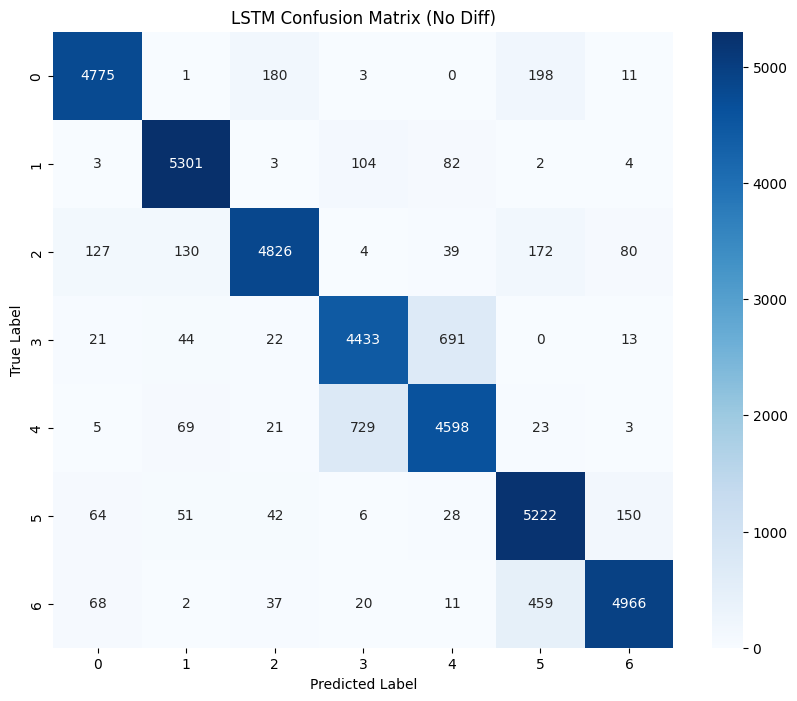

In [311]:
# Evaluate LSTM model
lstm_no_diff_loss, lstm_no_diff_accuracy = lstm_model_no_diff.evaluate(X_test_no_diff_lstm, y_test_no_diff_lstm, verbose=1)
print(f"LSTM Test Loss: {lstm_no_diff_loss:.4f}, Test Accuracy: {lstm_no_diff_accuracy:.4f}")
y_pred_no_diff_lstm = np.argmax(lstm_model_no_diff.predict(X_test_no_diff_lstm), axis=1)
print(classification_report(y_test_no_diff_lstm, y_pred_no_diff_lstm))
cm_lstm = confusion_matrix(y_test_no_diff_lstm, y_pred_no_diff_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [312]:
lstm_model_no_extra = create_lstm_model((X_train_no_extra_lstm.shape[1], X_train_no_extra_lstm.shape[2]))
lstm_model_no_extra.summary()

Model: "functional_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_63 (InputLayer)     │ (None, 50, 21)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 50, 64)         │        22,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_63 (LSTM)                  │ (None, 25)             │         9,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 25)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 12)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 7)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,117 (125.46 KB)

 Trainable params: 32,093 (125.36 KB)

 Non-trainable params: 24 (96.00 B)

In [313]:
lstm_model_no_extra.fit(X_train_no_extra_lstm, y_train_no_extra_lstm,
               validation_data=(X_val_no_extra_lstm, y_val_no_extra_lstm), 
               epochs=35, 
               batch_size=500, 
               verbose=1,
               callbacks=[lr_schedule])

Epoch 1/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.3981 - loss: 1.4503 - val_accuracy: 0.5305 - val_loss: 1.0478 - learning_rate: 0.0100
Epoch 2/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.5411 - loss: 1.0553 - val_accuracy: 0.5958 - val_loss: 0.9289 - learning_rate: 0.0100
Epoch 3/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.5636 - loss: 0.9908 - val_accuracy: 0.5951 - val_loss: 0.9157 - learning_rate: 0.0100
Epoch 4/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.5746 - loss: 0.9531 - val_accuracy: 0.5965 - val_loss: 0.8740 - learning_rate: 0.0100
Epoch 5/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.5949 - loss: 0.9100 - val_accuracy: 0.6353 - val_loss: 0.8326 - learning_rate: 0.0100
Epoch 6/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.5756 - loss: 0.9691 - val_accuracy: 0.4365 - val_loss: 1.4417 - learning_rate: 0.0100
Epoch 7/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.5292 - l

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
(37843, 7)
(37843,)
(37853,)
              precision    recall  f1-score   support

           0       0.83      0.68      0.75      5168
           1       0.96      0.93      0.94      5499
           2       0.71      0.86      0.78      5378
           3       0.83      0.90      0.86      5224
           4       0.87      0.83      0.85      5448
           5       0.73      0.81      0.77      5563
           6       0.95      0.81      0.87      5563

    accuracy                           0.83     37843
   macro avg       0.84      0.83      0.83     37843
weighted avg       0.84      0.83      0.83     37843



Text(95.72222222222221, 0.5, 'True Label')

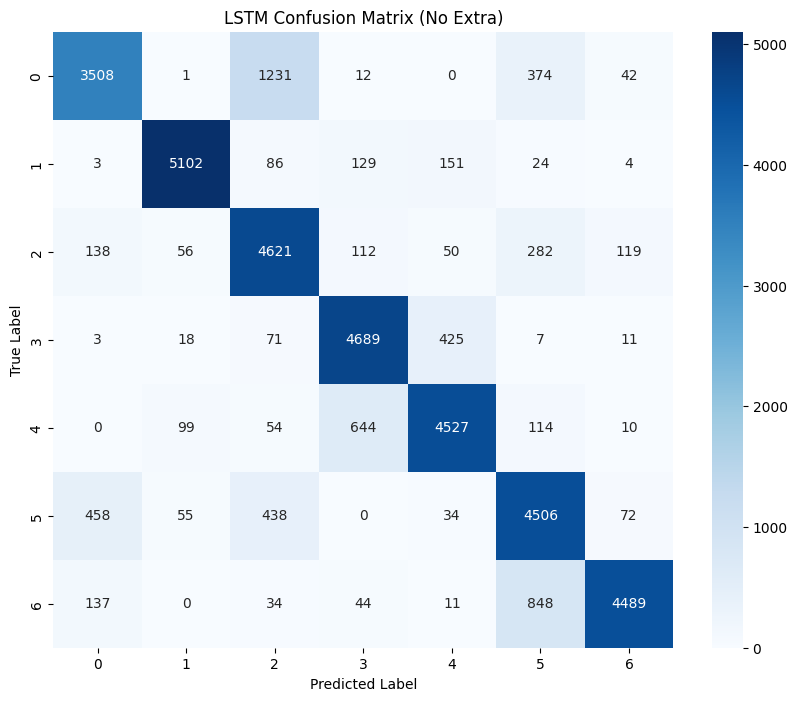

In [314]:
y_pred_no_extra_lstm = lstm_model_no_extra.predict(X_test_no_extra_lstm)
print(y_pred_no_extra_lstm.shape)
y_pred_no_extra_lstm = np.argmax(y_pred_no_extra_lstm, axis=1)
print(y_pred_no_extra_lstm.shape)
print(y_test.shape)
print(classification_report(y_test_no_extra_lstm, y_pred_no_extra_lstm))
cm_lstm = confusion_matrix(y_test_no_extra_lstm, y_pred_no_extra_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix (No Extra)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [315]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, Input


def create_cnn_lstm_model(input_shape):
    inputs = Input(shape=input_shape)  # (1, 21)
    
    # CNN part: learn patterns across the 21 features
    x = Conv1D(32, 1, activation='relu')(inputs)
    #x = MaxPooling1D(1)(x)
    x = Dropout(0.3)(x)
    
    #LSTM part: capture sequential relationships
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x= LSTM(32, return_sequences=False)(x)
    
    # Fully connected part
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(7, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model



In [316]:
cnn_lstm_model = create_cnn_lstm_model((X_train_no_diff_lstm.shape[1], X_train_no_diff_lstm.shape[2]))
cnn_lstm_model.summary()

# Train CNN-LSTM model
cnn_lstm_model.fit(X_train_no_diff_lstm, y_train_no_diff_lstm, 
               validation_data=(X_val_no_diff_lstm, y_val_no_diff_lstm), 
               epochs=35, 
               batch_size=500, 
               verbose=1,
               callbacks=[lr_schedule])

Model: "functional_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_64 (InputLayer)     │ (None, 50, 21)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 50, 32)         │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 50, 128)        │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_65 (LSTM)                  │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_165 (Dense)               │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,543 (287.28 KB)

 Trainable params: 73,543 (287.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - accuracy: 0.4293 - loss: 1.3152 - val_accuracy: 0.5466 - val_loss: 0.9881 - learning_rate: 0.0100
Epoch 2/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.5656 - loss: 0.9918 - val_accuracy: 0.5973 - val_loss: 0.9075 - learning_rate: 0.0100
Epoch 3/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.6076 - loss: 0.8570 - val_accuracy: 0.6279 - val_loss: 0.7735 - learning_rate: 0.0100
Epoch 4/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.6329 - loss: 0.7825 - val_accuracy: 0.6643 - val_loss: 0.7150 - learning_rate: 0.0100
Epoch 5/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.6639 - loss: 0.7336 - val_accuracy: 0.6917 - val_loss: 0.6542 - learning_rate: 0.0100
Epoch 6/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.6887 - loss: 0.6804 - val_accuracy: 0.7097 - val_loss: 0.6349 - learning_rate: 0.0100
Epoch 7/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.7076 - l

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
              precision    recall  f1-score   support

           0       0.85      0.65      0.74      5168
           1       0.98      0.88      0.92      5499
           2       0.90      0.80      0.84      5378
           3       0.61      0.70      0.65      5224
           4       0.57      0.66      0.61      5448
           5       0.65      0.58      0.62      5563
           6       0.70      0.87      0.77      5563

    accuracy                           0.73     37843
   macro avg       0.75      0.73      0.74     37843
weighted avg       0.75      0.73      0.74     37843



Text(95.72222222222221, 0.5, 'True Label')

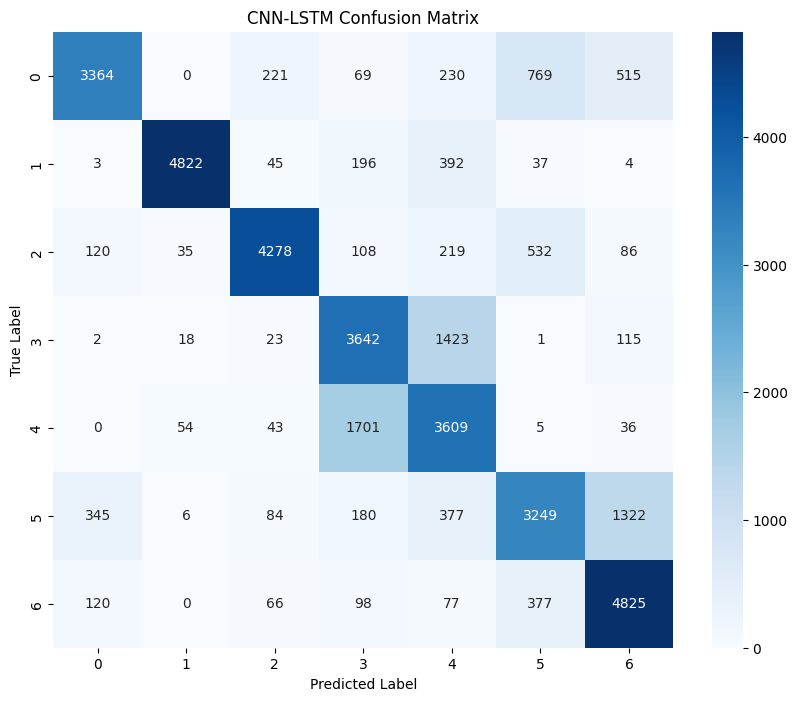

In [317]:
y_pred_cnn_lstm = np.argmax(cnn_lstm_model.predict(X_test_no_diff_lstm), axis=1)
print(classification_report(y_test_no_diff_lstm, y_pred_cnn_lstm))
cm_cnn_lstm = confusion_matrix(y_test_no_diff_lstm, y_pred_cnn_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('CNN-LSTM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [318]:
X_train_cnn_no_diff = X_train_no_diff.to_numpy().reshape((X_train_no_diff.shape[0], X_train_no_diff.shape[1], 1))
X_val_cnn_no_diff = X_val_no_diff.to_numpy().reshape((X_val_no_diff.shape[0], X_val_no_diff.shape[1], 1))
X_test_cnn_no_diff = X_test_no_diff.to_numpy().reshape((X_test_no_diff.shape[0], X_test_no_diff.shape[1], 1))

In [319]:
from keras.models import Sequential

def create_cnn_model(input_shape):
    model = Sequential()
    #model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    #model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(21, activation='relu'))
    model.add(Dense(11, activation='relu'))
    model.add(Dense(7, activation='softmax'))  # Use 'softmax' for multiclass
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model((X_train_no_diff.shape[1], 1))

In [320]:
cnn_model.fit(X_train_cnn_no_diff, y_train_no_diff,
              validation_data=(X_val_cnn_no_diff, y_val_no_diff),
              epochs=25,
              batch_size=500,
              verbose=1)


Epoch 1/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2530 - loss: 1.8725 - val_accuracy: 0.4197 - val_loss: 1.3917
Epoch 2/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.4263 - loss: 1.3483 - val_accuracy: 0.4422 - val_loss: 1.2816
Epoch 3/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.4536 - loss: 1.2669 - val_accuracy: 0.4816 - val_loss: 1.2386
Epoch 4/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.4974 - loss: 1.2221 - val_accuracy: 0.5172 - val_loss: 1.1919
Epoch 5/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.5244 - loss: 1.1694 - val_accuracy: 0.5251 - val_loss: 1.1456
Epoch 6/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5255 - loss: 1.1342 - val_accuracy: 0.5222 - val_loss: 1.1131
Epoch 7/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.5321 - loss: 1.1011 - val_accuracy: 0.5303 - val_loss: 1.0927
Epoch 8/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.5352 - loss: 1.0873 - val_

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
              precision    recall  f1-score   support

           0       0.14      0.18      0.16      5257
           1       0.14      0.13      0.14      5478
           2       0.14      0.13      0.14      5417
           3       0.13      0.15      0.14      5139
           4       0.14      0.18      0.16      5393
           5       0.15      0.12      0.13      5638
           6       0.16      0.12      0.14      5531

    accuracy                           0.14     37853
   macro avg       0.14      0.14      0.14     37853
weighted avg       0.14      0.14      0.14     37853



Text(95.72222222222221, 0.5, 'True Label')

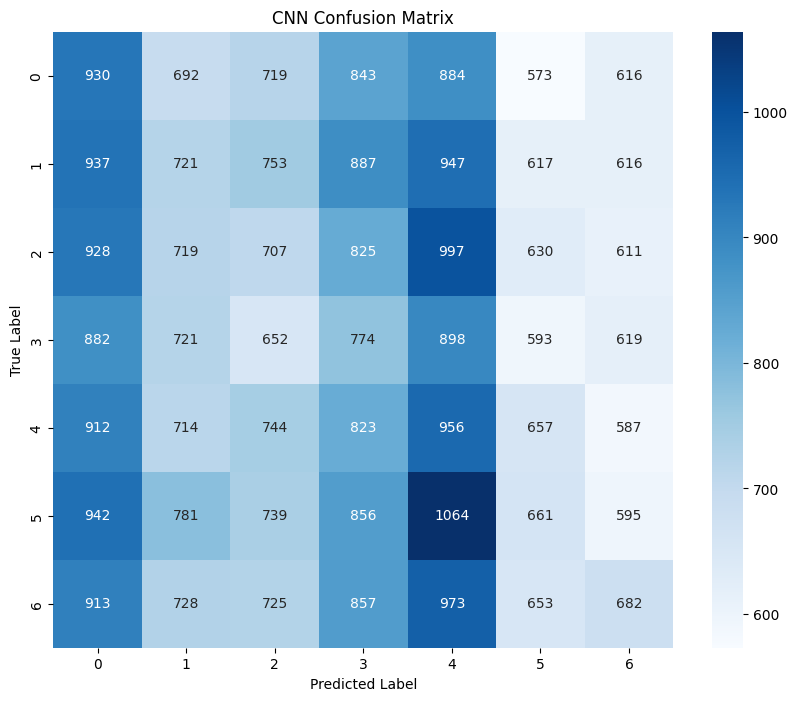

In [321]:
y_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn_no_diff), axis=1)
print(classification_report(y_test, y_pred_cnn))
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues')
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')